This file includes 

- select optimal $\kappa$ and save the results

- output example datasets

In [3]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN-AD")

In [4]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat,savemat
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import os
from scipy import signal
from tqdm import tqdm
import pickle
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
os.chdir("/home/huaqingj/MyResearch/TVDN-AD/")
resDir = Path("./results")
dataDir = Path("./data")

## Find the optimal kappa by Ctrl group

In [21]:
fil = list(resDir.glob("Ctrl*_tuningNum.pkl"))[0]
with open(fil, "rb") as f:
    nchgAll = pickle.load(f)

In [30]:
nchgsMeans = [np.array(detObjNum).mean(axis=0) for detObjNum in nchgAll]
nchgsVars = [np.array(detObjNum).var(axis=0) for detObjNum in nchgAll]

In [43]:
kps = np.linspace(1, 4, 1000)
nchgsMM = np.array(nchgsMeans).mean(axis=0)
nchgsVarM = np.array(nchgsVars).mean(axis=0)
idxs = np.bitwise_and(nchgsMM >=4, nchgsMM <=19)
optIdx = np.where(idxs)[0][0] + np.where((nchgsVarM[idxs].min() == nchgsVarM)[idxs])[0][-1]

In [44]:
optKp = kps[optIdx]

In [45]:
print(optKp, nchgsMM[optIdx])

2.798798798798799 5.111428571428572


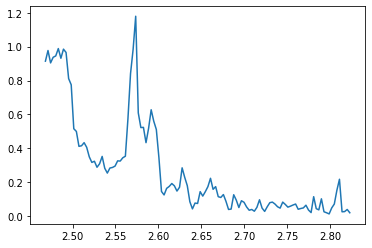

In [52]:
idxs = np.bitwise_and(nchgsMM >=4, nchgsMM <=19)
plt.plot(kps[idxs], nchgsVarM[idxs])

## Update kappa and save the results for both groups

In [30]:
print(optKp)

2.798798798798799


### Save ecpts under optimal Kappa

In [29]:
ecptss = []
ps = list(resDir.glob("Ctrl*04_decimate5.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    det.UpdateEcpts(det.numchgs[kps==optKp][0])
    ecptss.append(det.ecpts)
filName = f"Ctrl_data_lamb{det.paras.lamb:.1E}_ecpts.pkl"
with open(resDir/filName, "wb") as f:
    pickle.dump(ecptss, f)

100%|██████████| 70/70 [01:49<00:00,  1.56s/it]


In [31]:
ecptss = []
ps = list(resDir.glob("AD*04_decimate5.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    det.UpdateEcpts(det.numchgs[kps==optKp][0])
    ecptss.append(det.ecpts)
filName = f"AD_data_lamb{det.paras.lamb:.1E}_ecpts.pkl"
with open(resDir/filName, "wb") as f:
    pickle.dump(ecptss, f)

100%|██████████| 88/88 [02:12<00:00,  1.51s/it]


### Save eigVecs and eigVals under optimal Kappa

In [53]:
def GetFeatures(det):
    """
    obtain the eigvals and eigvectors for current ecpts
    """
    if det.RecResCur is None:
        det.GetRecResCur()
    Ur = det.midRes.eigVecs[:, :det.paras.r]
        
    lamMs = []
    for idx, ecpt in enumerate(np.concatenate([[0], det.ecpts])):
        lamM = det.RecResCur.LamMs[:, int(ecpt)]
        lamMs.append(lamM)
    
    det.curEigVecs = Ur
    det.curEigVals = lamMs

In [54]:
eigVecss = []
eigValss = []
ps = list(resDir.glob("Ctrl*04_decimate5.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    det.UpdateEcpts(det.numchgs[kps==optKp][0])
    GetFeatures(det)
    eigVecss.append(det.curEigVecs)
    eigValss.append(det.curEigVals)
filNameVecs = f"Ctrl_data_lamb{det.paras.lamb:.1E}_eigVecs.pkl"
filNameVals = f"Ctrl_data_lamb{det.paras.lamb:.1E}_eigVals.pkl"
with open(resDir/filNameVecs, "wb") as f:
    pickle.dump(eigVecss, f)
with open(resDir/filNameVals, "wb") as f:
    pickle.dump(eigValss, f)

100%|██████████| 70/70 [01:46<00:00,  1.52s/it]


In [55]:
eigVecss = []
eigValss = []
ps = list(resDir.glob("AD*04_decimate5.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    det.UpdateEcpts(det.numchgs[kps==optKp][0])
    GetFeatures(det)
    eigVecss.append(det.curEigVecs)
    eigValss.append(det.curEigVals)
filNameVecs = f"AD_data_lamb{det.paras.lamb:.1E}_eigVecs.pkl"
filNameVals = f"AD_data_lamb{det.paras.lamb:.1E}_eigVals.pkl"
with open(resDir/filNameVecs, "wb") as f:
    pickle.dump(eigVecss, f)
with open(resDir/filNameVals, "wb") as f:
    pickle.dump(eigValss, f)

100%|██████████| 88/88 [02:09<00:00,  1.47s/it]


### Save smoothed data in `mat` format

In [6]:
XmatsCtrl = {}
ps = list(resDir.glob("Ctrl*04_decimate5.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
flag = 0
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    XmatsCtrl[f"dat{flag}"] = det.Xmat
    flag += 1
filNameXmats = f"Ctrl_data_lamb{det.paras.lamb:.1E}_Xmats.mat"
savemat(resDir/filNameXmats, XmatsCtrl)

100%|██████████| 70/70 [01:49<00:00,  1.56s/it]


In [8]:
XmatsAD = {}
ps = list(resDir.glob("AD*04_decimate5.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
flag = 0
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    XmatsAD[f"dat{flag}"] = det.Xmat
    flag += 1
filNameXmats = f"AD_data_lamb{det.paras.lamb:.1E}_Xmats.mat"
savemat(resDir/filNameXmats, XmatsAD)

100%|██████████| 88/88 [02:17<00:00,  1.56s/it]


## Example

In [45]:
def plotRes(det, fname=None):
    plt.figure(figsize=[10, 10])
    plt.subplot(211)
    for i in range(68):
        plt.plot(det.ptime, det.nYmat[i, :])
    for j, ecpt in enumerate(det.ecpts):
        if j == 0:
            plt.axvline(ecpt/det.paras.freq, color="red", linestyle="--", label="Estimate")
        else:
            plt.axvline(ecpt/det.paras.freq, color="red", linestyle="--", label=None)
    plt.legend(loc="upper left")
    
    plt.subplot(212)
    for i in range(68):
        plt.plot(det.ptime, det.Xmat[i, :])
    for j, ecpt in enumerate(det.ecpts):
        if j == 0:
            plt.axvline(ecpt/det.paras.freq, color="red", linestyle="--", label="Estimate")
        else:
            plt.axvline(ecpt/det.paras.freq, color="red", linestyle="--", label=None)
    plt.legend(loc="upper left")
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')

In [47]:
filsAD =  list(resDir.glob("AD*04_decimate5.pkl"))
filsCtrl =  list(resDir.glob("Ctrl*04_decimate5.pkl"))

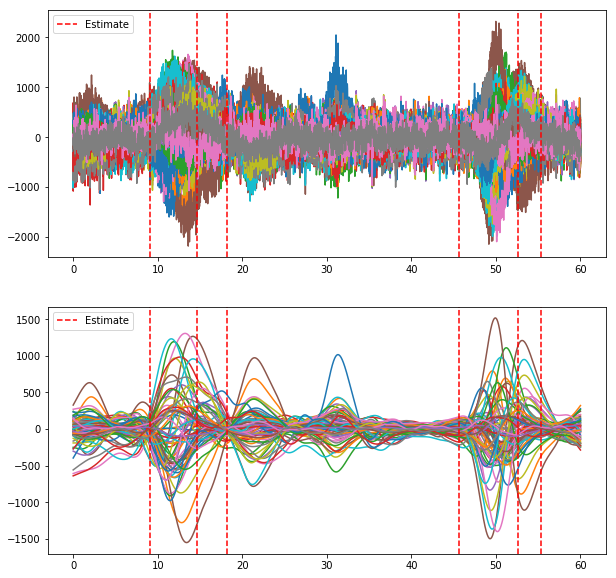

In [49]:
with open(filsAD[0], "rb") as f:
    detAD1 = pickle.load(f)
detAD1.UpdateEcpts(detAD1.numchgs[kps==optKp][0])
plotRes(detAD1, fname="./plots/exampleAD1.jpg")

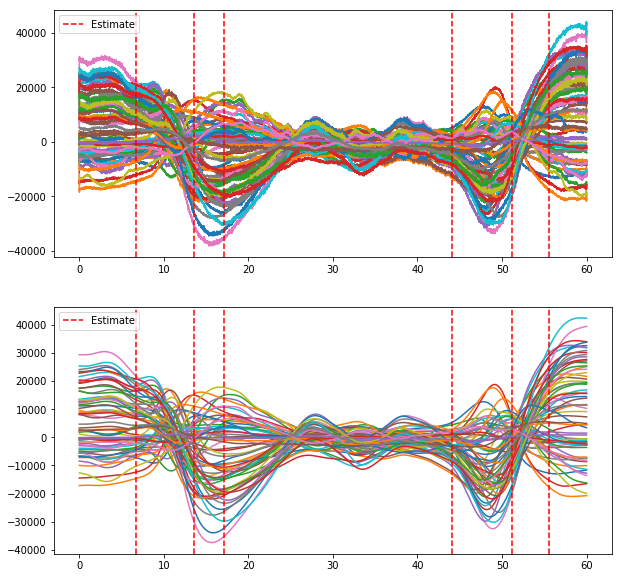

In [50]:
with open(filsAD[1], "rb") as f:
    detAD2 = pickle.load(f)
detAD2.UpdateEcpts(detAD2.numchgs[kps==optKp][0])
plotRes(detAD2, fname="./plots/exampleAD2.jpg")

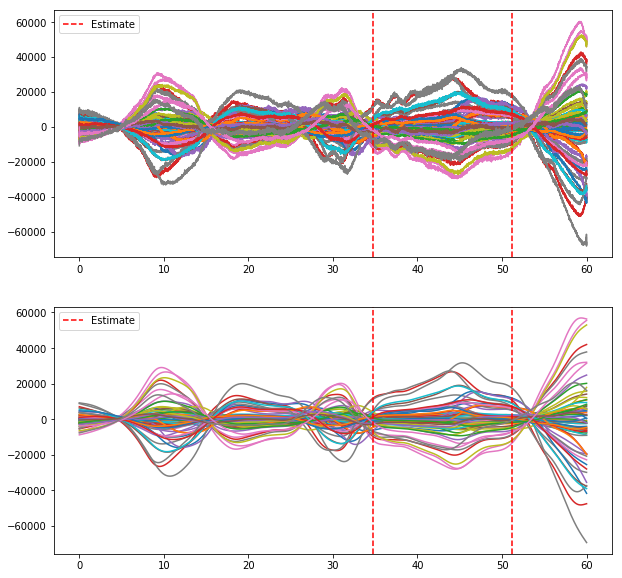

In [51]:
with open(filsCtrl[1], "rb") as f:
    detCtrl1 = pickle.load(f)
detCtrl1.UpdateEcpts(detCtrl1.numchgs[kps==optKp][0])
plotRes(detCtrl1, fname="./plots/exampleCtrl1.jpg")

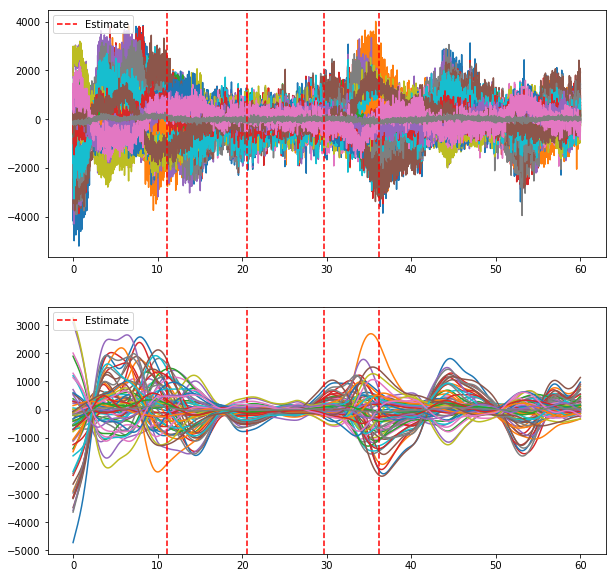

In [52]:
with open(filsCtrl[12], "rb") as f:
    detCtrl2 = pickle.load(f)
detCtrl2.UpdateEcpts(detCtrl2.numchgs[kps==optKp][0])
plotRes(detCtrl2, fname="./plots/exampleCtrl2.jpg")